<a href="https://colab.research.google.com/github/climate-and-health-datasci-Unicamp/ldl-cholesterol-climate-analysis/blob/master/models/Climate_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author:**
* [Daniela Souza de Oliveira](https://github.com/Danielaso)

*created in jun/2020*

## **Estimating Future Climate Data**

Seasonal auto regressive integrated moving average model (SARIMA) was used to model historical data from IAC. We used data from 1989 to 2018, period from 2014-2018 was used as test dataset.

Maximum and Minimum temperatures from 2019 to 2018 were estimated.

References to create model: References to create model: 

1. https://medium.com/@llmkhoa511/time-series-analysis-and-weather-forecast-in-python-e80b664c7f71
2. https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
3. https://www.analyticsvidhya.com/blog/2018/02/time-series-forecasting-methods/





INPUT:

[HW_IAC.csv](https://drive.google.com/file/d/1n96uNSGPlEO5RYEyaLqYMpevPpymK4KZ/view?usp=sharing), with Maximum and Minimum Temperatures for IAC weather station since 1956

OUTPUT:

[Forecasted_IAC.csv](https://drive.google.com/file/d/1Ls-gTTFdljOquzbgYuspsB6jF2Jrxnx5/view?usp=sharing), with Maximum and Minimum Temperatures predictions for IAC weather station from 2019 to 2028. 


In [1]:
# installing pmdarima library
!pip install -q pmdarima
!pip install -q tbats

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 18.4MB/s 
     |████████████████████████████████| 2.1MB 28.7MB/s 
     |████████████████████████████████| 51kB 1.6MB/s 


In [2]:
#importing libraries

import pandas as pd
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm

import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt
from pmdarima.arima import auto_arima

#from google.colab import drive
#from google.colab import files

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### **Loading data**



# 1.   HW_IAC.csv, historical IAC data -> df_IAC


---



In [3]:
#loading historical data to obtain climatological normal
googl = drive.CreateFile({'id':'1n96uNSGPlEO5RYEyaLqYMpevPpymK4KZ'})
googl.GetContentFile('HW_IAC.csv')
df_IAC = pd.read_csv('/content/HW_IAC.csv') #climatic normal dataframe

In [4]:
#removing unnecessary columns

del df_IAC['Unnamed: 0']
del df_IAC['N_RAIN_TOT']
del df_IAC['above_pct']
del df_IAC['HW']

In [5]:
#converting column 'DATE' to datetime format

df_IAC['DATE'] = pd.to_datetime(df_IAC['DATE'])

In [6]:
#extracting historical data to be used for prediction

df_IAC_tot = df_IAC.set_index('DATE')
df_IAC_tot = df_IAC_tot['1989-01-01':'2018-12-31']
df_IAC_total = df_IAC_tot.copy()

In [7]:
#defining training dataset

df_IAC_train = df_IAC.set_index('DATE')
df_IAC_train = df_IAC_train['1989-01-01' :'2013-12-31']

In [8]:
#defining test dataset

df_IAC_test = df_IAC.set_index('DATE')
df_IAC_test = df_IAC_test['2014-01-01' :'2018-12-31']

In [9]:
#defining Weekly frequency for all datasets

df_IAC_tot = df_IAC_tot.resample('W').mean()
df_IAC_train = df_IAC_train.resample('W').mean()
df_IAC_test = df_IAC_test.resample('W').mean()

In [10]:
df_IAC_train

,DAY365,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN
DATE,,,,
1989-01-01,1.0,1989.0,28.800000,19.600000
1989-01-08,5.0,1989.0,26.971429,19.457143
1989-01-15,12.0,1989.0,27.114286,19.485714
1989-01-22,19.0,1989.0,29.314286,18.885714
1989-01-29,26.0,1989.0,30.371429,19.085714
...,...,...,...,...
2013-12-08,339.0,2013.0,32.400000,20.071429
2013-12-15,346.0,2013.0,30.042857,19.414286
2013-12-22,353.0,2013.0,31.185714,18.528571


In [11]:
df_IAC_test

,DAY365,YEAR,N_AIRTMP_MAX,N_AIRTMP_MIN
DATE,,,,
2014-01-05,3.0,2014.0,32.840000,21.780000
2014-01-12,9.0,2014.0,33.114286,20.285714
2014-01-19,16.0,2014.0,31.357143,18.671429
2014-01-26,23.0,2014.0,32.900000,20.071429
2014-02-02,30.0,2014.0,34.328571,21.300000
...,...,...,...,...
2018-12-09,340.0,2018.0,29.300000,17.371429
2018-12-16,347.0,2018.0,32.628571,19.171429
2018-12-23,354.0,2018.0,33.642857,21.385714




## ---**Implementing model for Maximum Temperature**



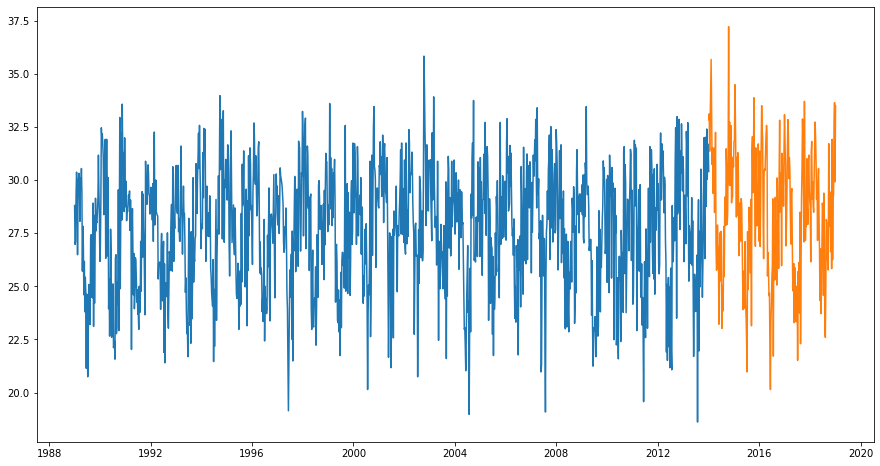

In [12]:
#visualizing training and test datasets

plt.figure(figsize=(15,8))
plt.plot(df_IAC_train['N_AIRTMP_MAX'])
plt.plot(df_IAC_test['N_AIRTMP_MAX'])
plt.show()

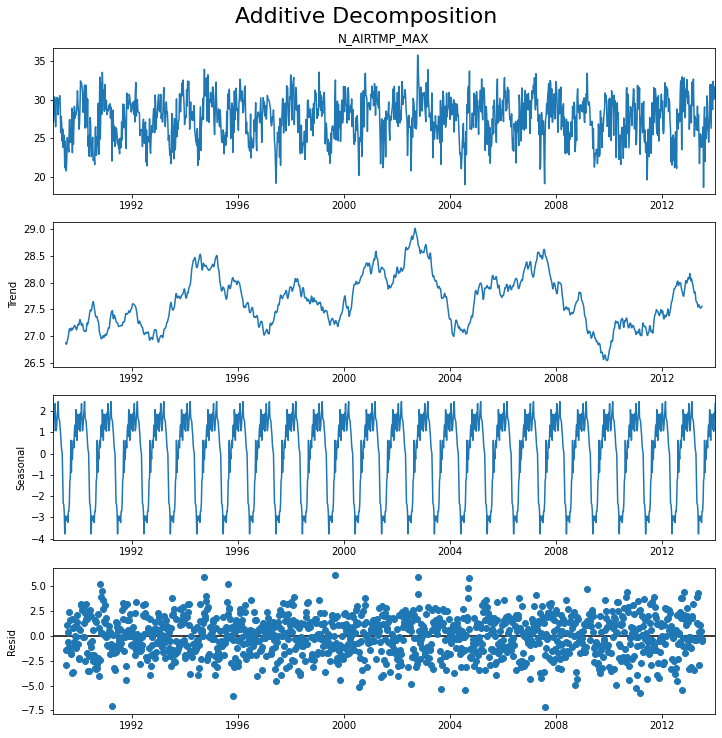

In [13]:
# Additive Tmax Decomposition

result_addTmax = seasonal_decompose(df_IAC_train['N_AIRTMP_MAX'], model='additive',period=52)

# Plot Tmax Decomposition

plt.rcParams.update({'figure.figsize': (10,10)})
result_addTmax.plot().suptitle('Additive Decomposition', fontsize=22,y=1.02)
plt.show()

In [14]:
#uses auto_arima to find the model parameters which give the smaller AIC

#Tmax_search = auto_arima(df_IAC_train.N_AIRTMP_MAX, start_p=1, start_q=1,
#                          max_p=2, max_q=2, m=52,
#                          start_P=0, seasonal=True,
#                          d=1, D=1, trace=True,
#                          error_action='ignore',  
#                          suppress_warnings=True, 
#                          stepwise=True)

In [15]:
# checking residues

residTmax = result_addTmax.resid

In [16]:
residTmax.describe()

count    1254.000000
mean        0.004057
std         1.987596
min        -7.173688
25%        -1.352574
50%         0.043291
75%         1.393756
max         6.168185
Name: resid, dtype: float64

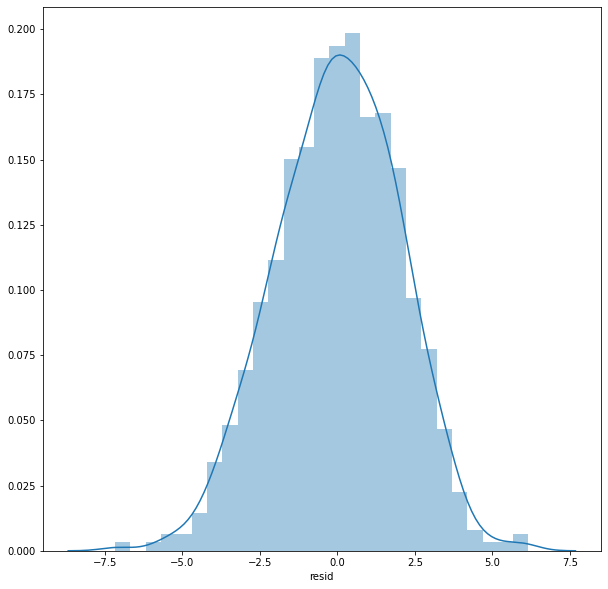

In [17]:
# Checking residues distribution

sns.distplot(residTmax)

In [18]:
#fitting SARIMAX model for Tmax with smaller AIC
#Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=5512.474, BIC=5538.140, Time=266.460 seconds
#Fit ARIMA(1,1,1)x(0,1,2,52) [intercept=True]; AIC=5511.467, BIC=5542.267, Time=1001.862 seconds

mod_Tmax = sm.tsa.statespace.SARIMAX(df_IAC_train['N_AIRTMP_MAX'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
Tmax_result = mod_Tmax.fit()

print(Tmax_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       N_AIRTMP_MAX   No. Observations:                 1306
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2622.066
Date:                            Wed, 01 Jul 2020   AIC                           5252.131
Time:                                    12:14:30   BIC                           5272.488
Sample:                                01-01-1989   HQIC                          5259.800
                                     - 01-05-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1993      0.028      7.008      0.000       0.144       0.255
ma.L1         -0.9813      0.006   

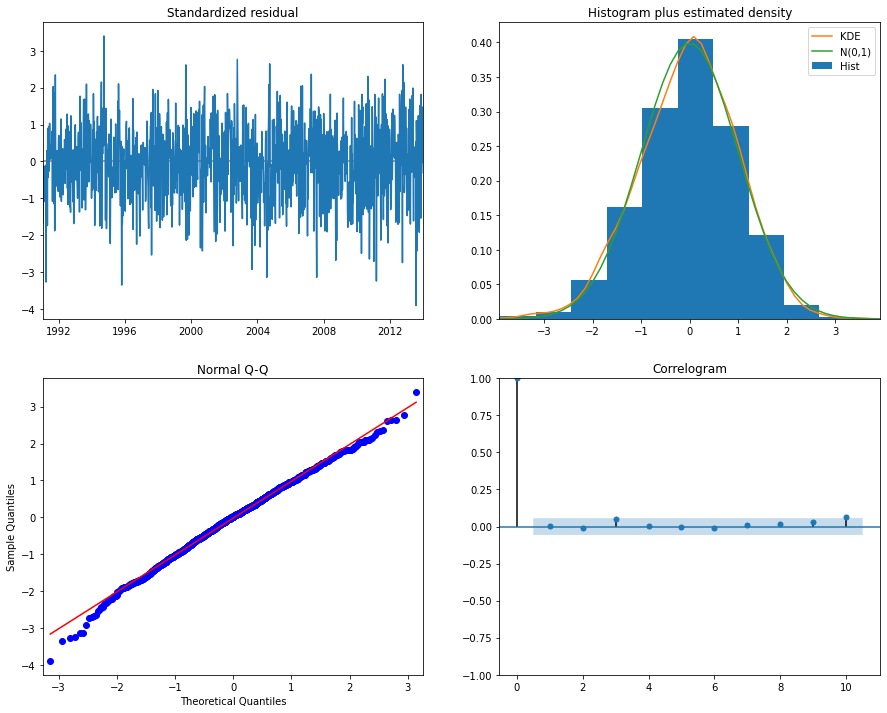

In [19]:
Tmax_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [20]:
#predicting data for the next 5 years (2014-2018)
#get_forecast allows constructing confidence intervals
Tmax_pred = Tmax_result.get_forecast(steps=262)
Tmax_pred_ci = Tmax_pred.conf_int()

In [21]:
Tmax_pred_ci

,lower N_AIRTMP_MAX,upper N_AIRTMP_MAX
2014-01-12,24.896468,33.076752
2014-01-19,24.458698,32.831119
2014-01-26,24.771961,33.159811
2014-02-02,25.304242,33.695943
2014-02-09,25.583085,33.977251
...,...,...
2018-12-16,25.289064,34.406172
2018-12-23,24.971738,34.091725
2018-12-30,25.541261,34.664116
2019-01-06,24.434617,33.581320




###**Plot to compare predicted and test dataset**



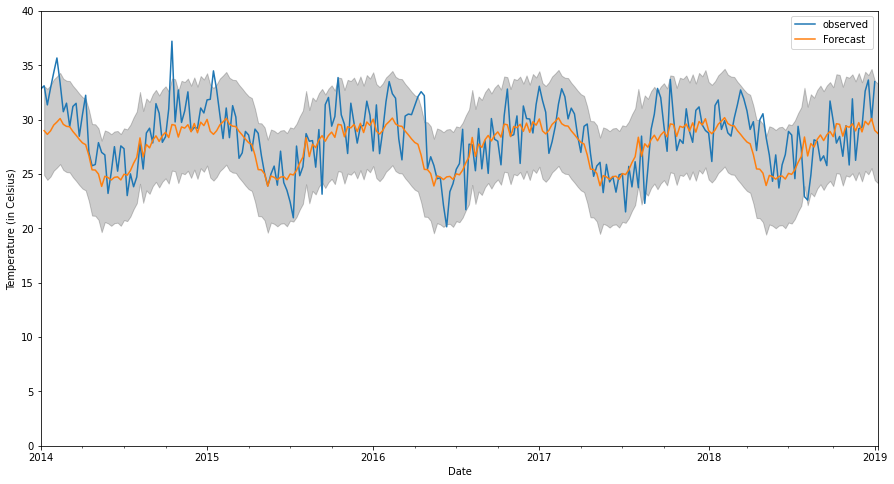

In [22]:
ax = df_IAC_test.N_AIRTMP_MAX.plot(label='observed',figsize=(15,8)) #plot historical dataset
Tmax_pred.predicted_mean.plot(ax=ax, label='Forecast') #plot predicted dataset

ax.fill_between(Tmax_pred_ci.index,
                Tmax_pred_ci.iloc[:, 0],
                Tmax_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,40])
plt.legend()
plt.show()


In [23]:
#checking error
Tmax_forecasted = Tmax_pred.predicted_mean
Tmax_truth = df_IAC_test['N_AIRTMP_MAX']
print(Tmax_forecasted.shape)
print(Tmax_truth.shape)

mse = sqrt(MSE(Tmax_truth, Tmax_forecasted).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(262,)
(262,)
The Mean Squared Error of our forecasts is 2.52


In [24]:
#predicting data from 2014 until 2028
Tmax_pred = Tmax_result.get_forecast(steps=782)
Tmax_pred_ci = Tmax_pred.conf_int()

In [25]:
Tmax_pred_ci

,lower N_AIRTMP_MAX,upper N_AIRTMP_MAX
2014-01-12,24.896468,33.076752
2014-01-19,24.458698,32.831119
2014-01-26,24.771961,33.159811
2014-02-02,25.304242,33.695943
2014-02-09,25.583085,33.977251
...,...,...
2028-12-03,24.376835,35.721011
2028-12-10,24.058713,35.407360
2028-12-17,24.627444,35.980542
2028-12-24,23.520074,34.898472


###**Plot to compare chosen historical data with forecasted data**


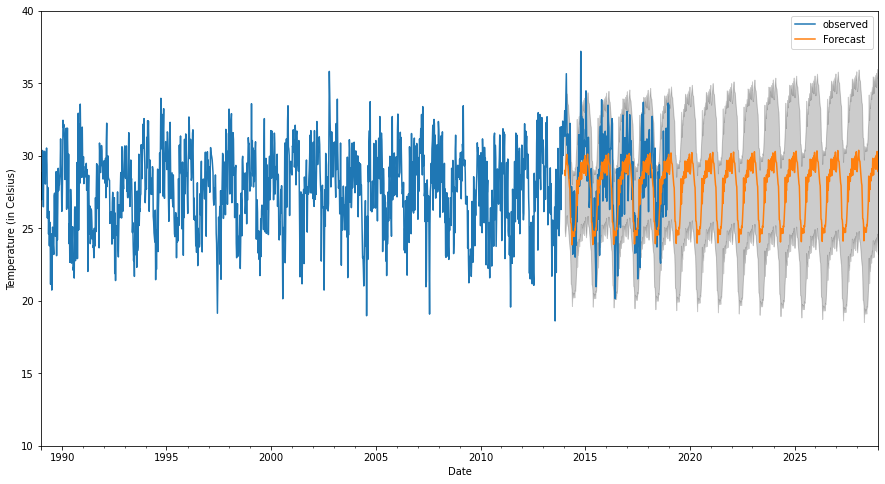

In [26]:
ax = df_IAC_tot.N_AIRTMP_MAX.plot(label='observed',figsize=(15,8)) #plot historical dataset
Tmax_pred.predicted_mean.plot(ax=ax, label='Forecast') #plot predicted dataset

ax.fill_between(Tmax_pred_ci.index,
                Tmax_pred_ci.iloc[:, 0],
                Tmax_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([10,40])
plt.legend()
plt.show()

In [27]:
#obtaining forecasted data points from 2014 to 2028
Tmax_forecast = Tmax_result.forecast(782)
Tmax_forecast.round(2)

2014-01-12    28.99
2014-01-19    28.64
2014-01-26    28.97
2014-02-02    29.50
2014-02-09    29.78
              ...  
2028-12-03    30.05
2028-12-10    29.73
2028-12-17    30.30
2028-12-24    29.21
2028-12-31    28.93
Freq: W-SUN, Length: 782, dtype: float64

###**Plot of forecasted data (2014 to 2028)**

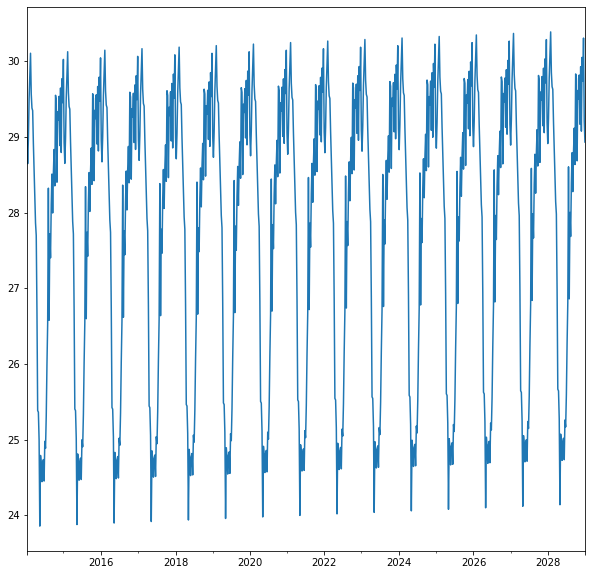

In [28]:
Tmax_forecast.plot()
plt.rcParams['figure.figsize'] = 15, 30

In [29]:
#generating dataframe with forecasted data

Tmax_data = Tmax_forecast
df_Tmax = pd.DataFrame(data=Tmax_data, columns=['Forecasted_Tmax'])
df_Tmax

,Forecasted_Tmax
2014-01-12,28.986610
2014-01-19,28.644908
2014-01-26,28.965886
2014-02-02,29.500093
2014-02-09,29.780168
...,...
2028-12-03,30.048923
2028-12-10,29.733037
2028-12-17,30.303993
2028-12-24,29.209273


In [30]:
#Converting data to daily data

df_IAC_Tmax = df_Tmax.resample('D').mean()
df_IAC_Tmax

,Forecasted_Tmax
2014-01-12,28.986610
2014-01-13,NaN
2014-01-14,NaN
2014-01-15,NaN
2014-01-16,NaN
...,...
2028-12-27,NaN
2028-12-28,NaN
2028-12-29,NaN
2028-12-30,NaN


In [31]:
#Interpolating data to complete daily data

df_IAC_Tmax = df_IAC_Tmax.interpolate(method='time')
df_IAC_Tmax = df_IAC_Tmax.round(2)
df_IAC_Tmax

,Forecasted_Tmax
2014-01-12,28.99
2014-01-13,28.94
2014-01-14,28.89
2014-01-15,28.84
2014-01-16,28.79
...,...
2028-12-27,29.09
2028-12-28,29.05
2028-12-29,29.01
2028-12-30,28.97


In [32]:
#Selecting data from 2019 to 2028

df_IAC_Tmax = df_IAC_Tmax[df_IAC_Tmax.index.year>=2019]

In [33]:
df_IAC_Tmax.describe()

,Forecasted_Tmax
count,3653.000000
mean,27.881528
std,1.859849
min,23.960000
25%,26.000000
50%,28.590000
75%,29.460000
max,30.390000



### **Plot showing historical and forecasted data**

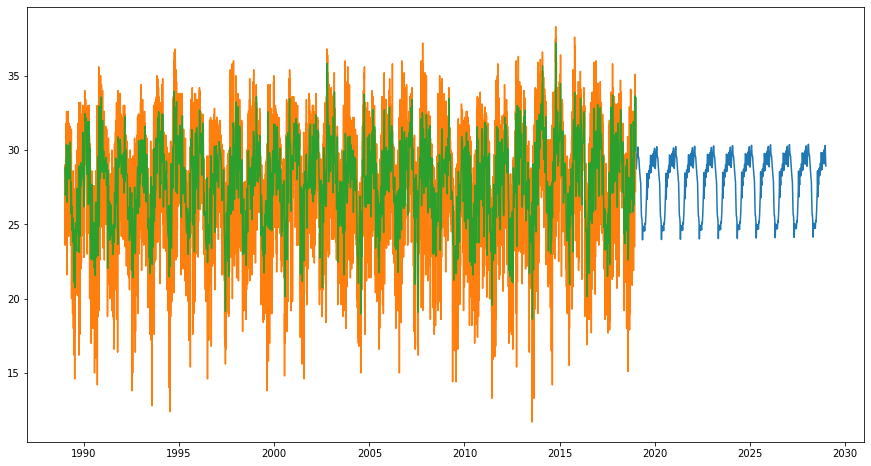

In [34]:
plt.figure(figsize=(15,8))
plt.plot(df_IAC_Tmax['Forecasted_Tmax']) #forecasted data
plt.plot(df_IAC_total['N_AIRTMP_MAX']) #historical daily data
plt.plot(df_IAC_tot['N_AIRTMP_MAX']) #weekly data
plt.show()

### **Adding noise to data**

As seen from last figure, our forecasting is not accurate because it predicts well the data seasonality but it doesn't take into account the 'residuals' or noise of the data. Without this noise our model would not be able to detect coldwaves.

We tried adding noise to data to see if we could detect coldwaves.

References:

1. https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

2. https://machinelearningmastery.com/model-residual-errors-correct-time-series-forecasts-python/





In [35]:
df_IAC_total = df_IAC_total.fillna(method='ffill')

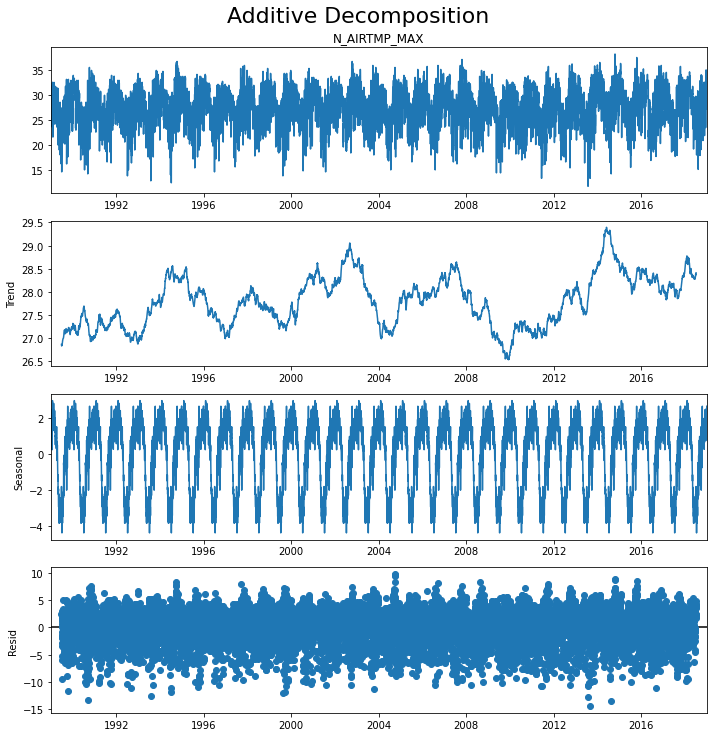

In [36]:
# Additive historical data Decomposition

result_addTotal = seasonal_decompose(df_IAC_total['N_AIRTMP_MAX'], model='additive',period=365)

# Plot Decomposition

plt.rcParams.update({'figure.figsize': (10,10)})
result_addTotal.plot().suptitle('Additive Decomposition', fontsize=22,y=1.02)
plt.show()

In [37]:
noise_tot = result_addTotal.resid

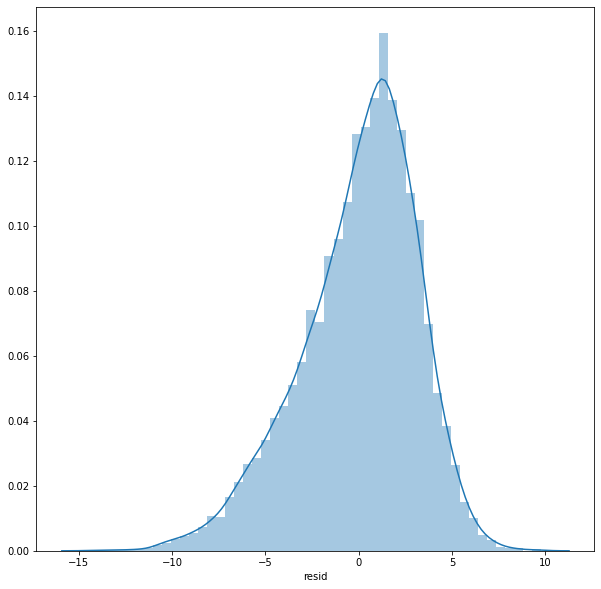

In [38]:
sns.distplot(noise_tot)

In [39]:
noise_tot.describe()

count    10586.000000
mean         0.000713
std          3.132709
min        -14.411002
25%         -1.824849
50%          0.459834
75%          2.219907
max          9.774884
Name: resid, dtype: float64

In [40]:
df_IAC_Tmax.shape

(3653, 1)

In [41]:
#estimating noise from data residues

noise = np.random.normal(0.000713,3.132709,3653)

In [42]:
df_noise = pd.DataFrame(data=noise,index=df_IAC_Tmax.index)

In [43]:
# adding noise to the data
df_addNoise = df_IAC_Tmax['Forecasted_Tmax'].add(df_noise[0], fill_value=0)

In [44]:
df_addNoise

2019-01-01    29.108870
2019-01-02    29.494062
2019-01-03    30.872567
2019-01-04    30.420183
2019-01-05    23.246061
                ...    
2028-12-27    33.340101
2028-12-28    33.386675
2028-12-29    28.252276
2028-12-30    29.054669
2028-12-31    24.507097
Freq: D, Length: 3653, dtype: float64

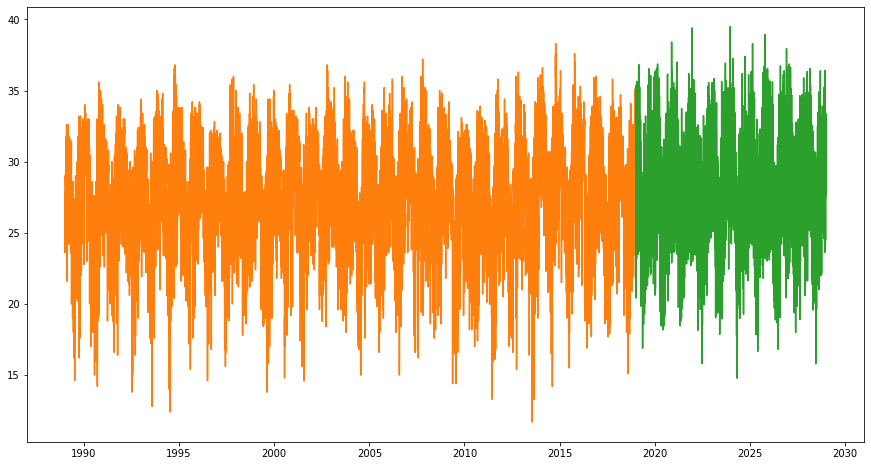

In [45]:
plt.figure(figsize=(15,8))
plt.plot(df_IAC_Tmax['Forecasted_Tmax']) #forecasted data
plt.plot(df_IAC_total['N_AIRTMP_MAX']) #historical daily data
plt.plot(df_addNoise)
plt.show()

##**---Implementing model for Minimum Temperature**

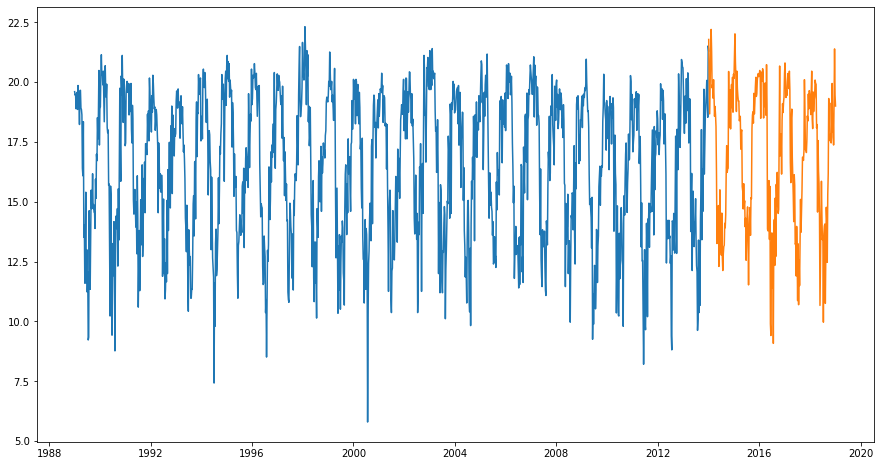

In [46]:
#visualizing training and test datasets

plt.figure(figsize=(15,8))
plt.plot(df_IAC_train['N_AIRTMP_MIN'])
plt.plot(df_IAC_test['N_AIRTMP_MIN'])
plt.show()

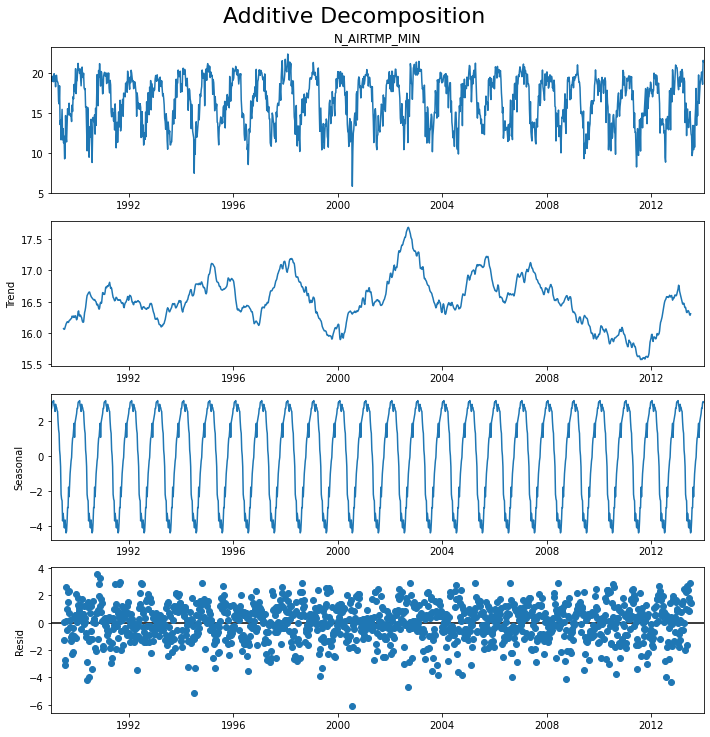

In [47]:
# Additive Tmin Decomposition

result_addTmin = seasonal_decompose(df_IAC_train['N_AIRTMP_MIN'], model='additive',period=52)

# Plot Tmin Decomposition

plt.rcParams.update({'figure.figsize': (10,10)})
result_addTmin.plot().suptitle('Additive Decomposition', fontsize=22,y=1.02)
plt.show()

In [48]:
#Tmin_search = auto_arima(df_IAC_train.N_AIRTMP_MIN, start_p=2, start_q=1,
#                           max_p=2, max_q=2, m=52,
#                           start_P=0, seasonal=True,
#                           d=1, D=1, trace=True,
#                           error_action='ignore',  
#                           suppress_warnings=True, 
#                           stepwise=True)

In [49]:
#fitting model for Tmax with best AIC
#Fit ARIMA(1,1,1)x(0,1,1,52) [intercept=True]; AIC=4510.439, BIC=4536.105, Time=222.937 seconds

mod_Tmin = sm.tsa.statespace.SARIMAX(df_IAC_train['N_AIRTMP_MIN'],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 52),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

Tmin_result = mod_Tmin.fit()

print(Tmin_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       N_AIRTMP_MIN   No. Observations:                 1306
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -2129.074
Date:                            Wed, 01 Jul 2020   AIC                           4266.148
Time:                                    12:15:59   BIC                           4286.505
Sample:                                01-01-1989   HQIC                          4273.817
                                     - 01-05-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3038      0.027     11.147      0.000       0.250       0.357
ma.L1         -0.9795      0.006   

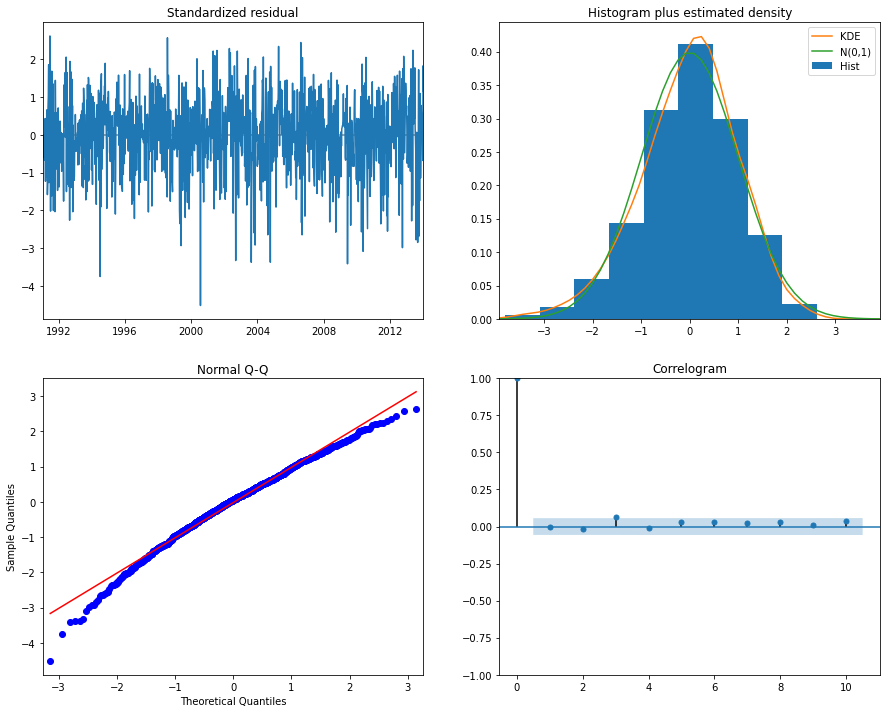

In [50]:
Tmin_result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [51]:
#predicting data for the next 5 years (2014-2018)

Tmin_pred = Tmin_result.get_forecast(steps=262)
Tmin_pred_ci = Tmin_pred.conf_int()

In [52]:
Tmin_pred_ci

,lower N_AIRTMP_MIN,upper N_AIRTMP_MIN
2014-01-12,17.060319,22.537572
2014-01-19,16.112576,21.870681
2014-01-26,16.064798,21.859680
2014-02-02,16.027083,21.830257
2014-02-09,16.339566,22.146405
...,...,...
2018-12-16,15.852669,22.645046
2018-12-23,16.087304,22.883516
2018-12-30,15.833158,22.633198
2019-01-06,15.711140,22.558353


###**Plot to compare predicted and test dataset**

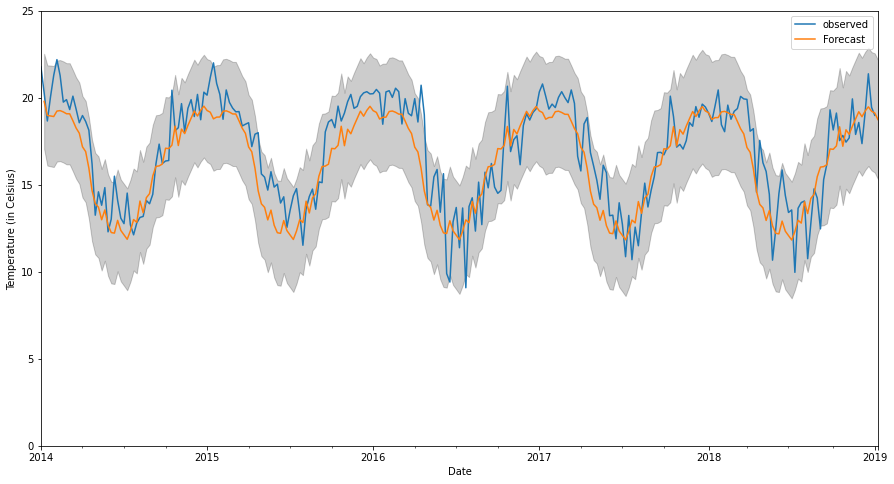

In [53]:
ax = df_IAC_test.N_AIRTMP_MIN.plot(label='observed',figsize=(15,8)) #test dataset
Tmin_pred.predicted_mean.plot(ax=ax, label='Forecast') #predicted dataset

ax.fill_between(Tmin_pred_ci.index, #confidence interval
                Tmin_pred_ci.iloc[:, 0],
                Tmin_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,25])
plt.legend()
plt.show()

In [54]:
#checking error
Tmin_forecasted = Tmin_pred.predicted_mean
Tmin_truth = df_IAC_test['N_AIRTMP_MIN']
print(Tmin_forecasted.shape)
print(Tmin_truth.shape)

mse = sqrt(MSE(Tmin_truth, Tmin_forecasted).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

(262,)
(262,)
The Mean Squared Error of our forecasts is 1.72


In [55]:
Tmin_pred = Tmin_result.get_forecast(steps=782)
Tmin_pred_ci = Tmin_pred.conf_int()

###**Plot to compare chosen historical data with forecasted data**


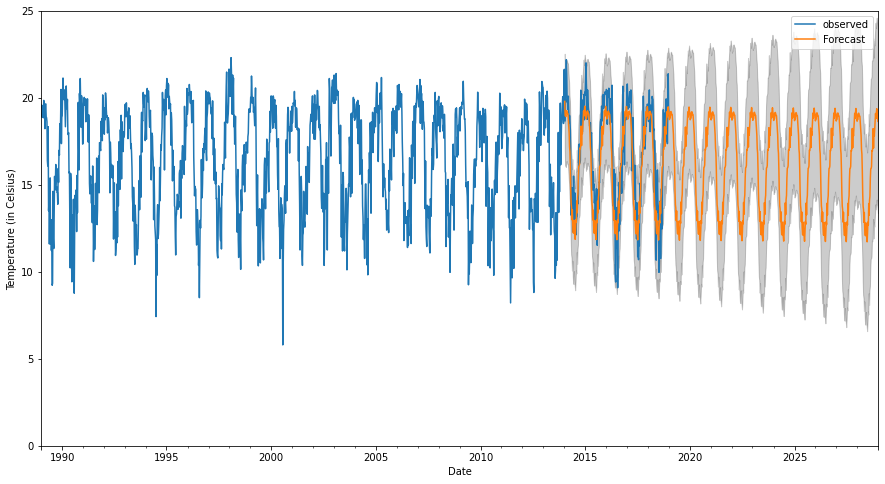

In [56]:
ax = df_IAC_tot.N_AIRTMP_MIN.plot(label='observed',figsize=(15,8))
Tmin_pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(Tmin_pred_ci.index,
                Tmin_pred_ci.iloc[:, 0],
                Tmin_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([0,25])
plt.legend()
plt.show()

In [57]:
#obtaing forecasted data points from 2014 to 2028

Tmin_forecast = Tmin_result.forecast(782)
Tmin_forecast.round(2)

2014-01-12    19.80
2014-01-19    18.99
2014-01-26    18.96
2014-02-02    18.93
2014-02-09    19.24
              ...  
2028-12-03    19.14
2028-12-10    19.38
2028-12-17    19.13
2028-12-24    19.03
2028-12-31    18.65
Freq: W-SUN, Length: 782, dtype: float64

###**Plot of forecasted data (2014 to 2028)**

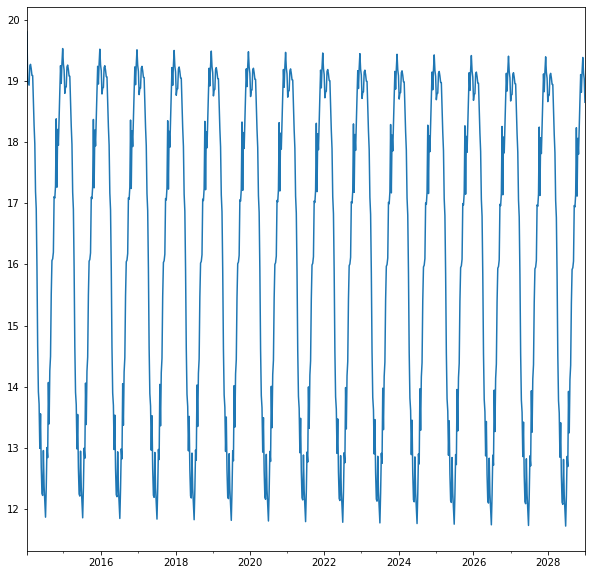

In [58]:
Tmin_forecast.plot()
plt.rcParams['figure.figsize'] = 15, 30

In [59]:
#generating dataframe with forecasted data

Tmin_data = Tmin_forecast
df_Tmin = pd.DataFrame(data=Tmin_data, columns=['Forecasted_Tmin'])
df_Tmin

,Forecasted_Tmin
2014-01-12,19.798945
2014-01-19,18.991628
2014-01-26,18.962239
2014-02-02,18.928670
2014-02-09,19.242986
...,...
2028-12-03,19.144859
2028-12-10,19.381412
2028-12-17,19.129179
2028-12-24,19.030748


In [60]:
#Converting data to daily data

df_IAC_Tmin = df_Tmin.resample('D').mean()
df_IAC_Tmin

,Forecasted_Tmin
2014-01-12,19.798945
2014-01-13,NaN
2014-01-14,NaN
2014-01-15,NaN
2014-01-16,NaN
...,...
2028-12-27,NaN
2028-12-28,NaN
2028-12-29,NaN
2028-12-30,NaN


In [61]:
#Interpolating data to complete daily data

df_IAC_Tmin = df_IAC_Tmin.interpolate(method='time')
df_IAC_Tmin = df_IAC_Tmin.round(2)
df_IAC_Tmin

,Forecasted_Tmin
2014-01-12,19.80
2014-01-13,19.68
2014-01-14,19.57
2014-01-15,19.45
2014-01-16,19.34
...,...
2028-12-27,18.87
2028-12-28,18.81
2028-12-29,18.76
2028-12-30,18.70


In [62]:
#Selecting data from 2019 to 2028

df_IAC_Tmin = df_IAC_Tmin[df_IAC_Tmin.index.year>=2019]

In [63]:
df_IAC_Tmin.describe()

,Forecasted_Tmin
count,3653.000000
mean,16.202685
std,2.602155
min,11.730000
25%,13.510000
50%,16.990000
75%,18.800000
max,19.480000



### **Plot showing historical and forecasted data**

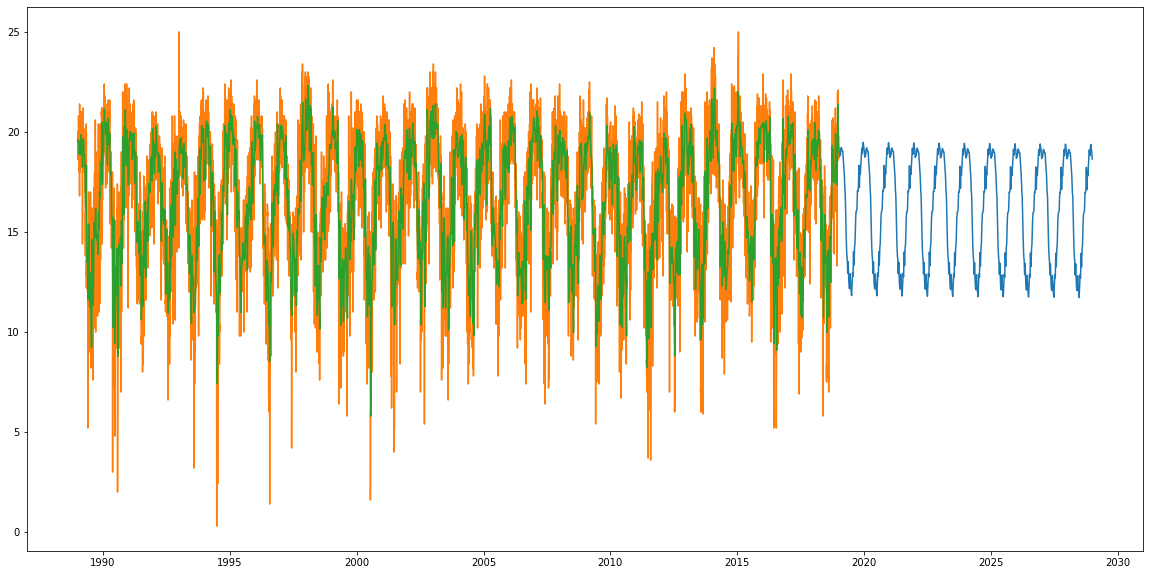

In [64]:
plt.figure(figsize=(20,10))
plt.plot(df_IAC_Tmin['Forecasted_Tmin']) #forecasted data
plt.plot(df_IAC_total['N_AIRTMP_MIN']) #daily historical data
plt.plot(df_IAC_tot['N_AIRTMP_MIN']) #weekly historical data
plt.show()

### **Adding noise to data**

As seen from last figure, our forecasting is not accurate because it predicts well the data seasonality but it doesn't take into account the 'residuals' or noise of the data. Without this noise our model would not be able to detect coldwaves.

We tried adding noise to data to see if we could detect coldwaves.



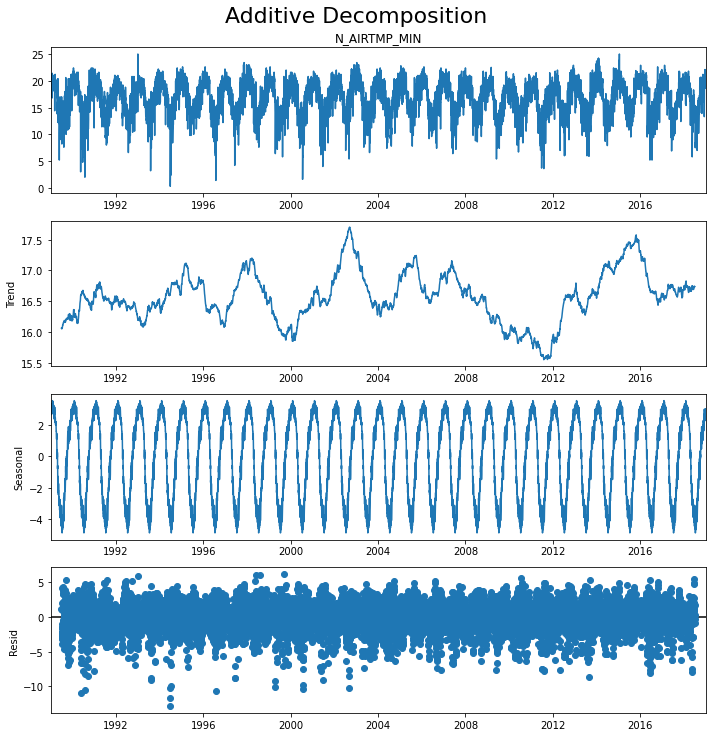

In [65]:
# Additive historical data Decomposition

result_addTotalMin = seasonal_decompose(df_IAC_total['N_AIRTMP_MIN'], model='additive',period=365)

# Plot Decomposition

plt.rcParams.update({'figure.figsize': (10,10)})
result_addTotalMin.plot().suptitle('Additive Decomposition', fontsize=22,y=1.02)
plt.show()

In [66]:
noise_totMin = result_addTotalMin.resid

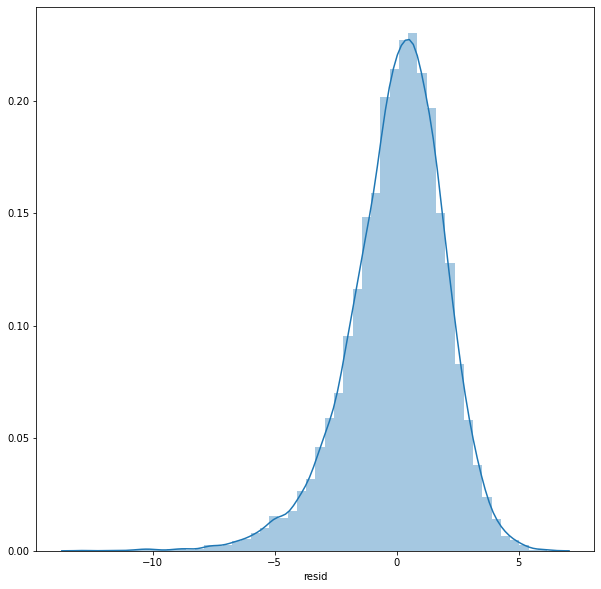

In [67]:
sns.distplot(noise_totMin)

In [68]:
noise_totMin.describe()

count    10586.000000
mean        -0.003201
std          1.975602
min        -12.826659
25%         -1.107391
50%          0.185122
75%          1.315597
max          6.163478
Name: resid, dtype: float64

In [69]:
df_IAC_Tmin

,Forecasted_Tmin
2019-01-01,19.21
2019-01-02,19.19
2019-01-03,19.18
2019-01-04,19.16
2019-01-05,19.15
...,...
2028-12-27,18.87
2028-12-28,18.81
2028-12-29,18.76
2028-12-30,18.70


In [70]:
df_IAC_Tmin.shape

(3653, 1)

In [71]:
noiseMin = np.random.normal(-0.003201,1.975602,3653)

In [72]:
df_noiseMin = pd.DataFrame(data=noiseMin,index=df_IAC_Tmin.index)

In [73]:
df_addNoiseMin = df_IAC_Tmin['Forecasted_Tmin'].add(df_noiseMin[0], fill_value=0)

In [74]:
df_addNoiseMin

2019-01-01    17.863364
2019-01-02    21.163228
2019-01-03    21.346615
2019-01-04    20.221684
2019-01-05    20.554670
                ...    
2028-12-27    19.183667
2028-12-28    22.283497
2028-12-29    17.603182
2028-12-30    20.375251
2028-12-31    18.389197
Freq: D, Length: 3653, dtype: float64

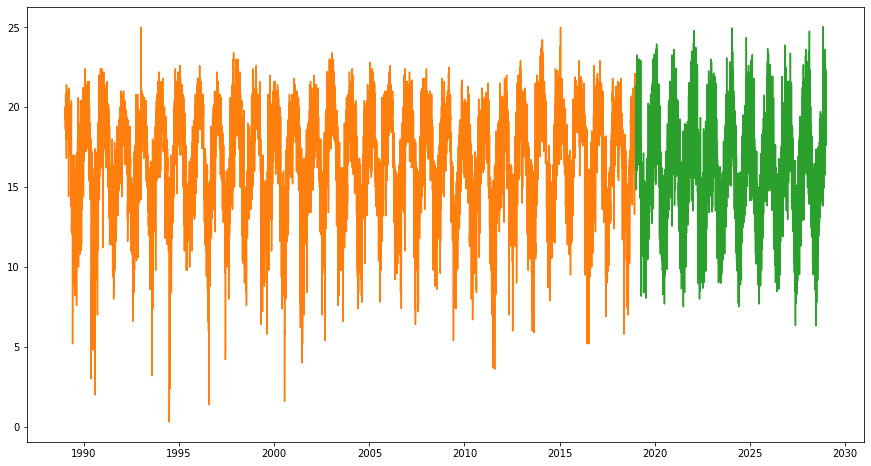

In [75]:
plt.figure(figsize=(15,8))
plt.plot(df_IAC_Tmin['Forecasted_Tmin']) #forecasted data
plt.plot(df_IAC_total['N_AIRTMP_MIN']) #historical daily data
plt.plot(df_addNoiseMin)
plt.show()

###**Merging df_IAC_Tmax and df_IAC_Tmin**

In [76]:
# resetting index Tmax
df_addNoise = df_addNoise.reset_index()
df_addNoise = df_addNoise.rename(columns={0:'Forecasted_Tmax'})
df_addNoise

,index,Forecasted_Tmax
0,2019-01-01,29.108870
1,2019-01-02,29.494062
2,2019-01-03,30.872567
3,2019-01-04,30.420183
4,2019-01-05,23.246061
...,...,...
3648,2028-12-27,33.340101
3649,2028-12-28,33.386675
3650,2028-12-29,28.252276
3651,2028-12-30,29.054669


In [77]:
# resetting index Tmin

df_addNoiseMin = df_addNoiseMin.reset_index()
df_addNoiseMin = df_addNoiseMin.rename(columns={0:'Forecasted_Tmin'})
df_addNoiseMin

,index,Forecasted_Tmin
0,2019-01-01,17.863364
1,2019-01-02,21.163228
2,2019-01-03,21.346615
3,2019-01-04,20.221684
4,2019-01-05,20.554670
...,...,...
3648,2028-12-27,19.183667
3649,2028-12-28,22.283497
3650,2028-12-29,17.603182
3651,2028-12-30,20.375251


In [78]:
df_addNoiseMin.dtypes

index              datetime64[ns]
Forecasted_Tmin           float64
dtype: object

In [79]:
df_addNoiseMin.head()

,index,Forecasted_Tmin
0,2019-01-01,17.863364
1,2019-01-02,21.163228
2,2019-01-03,21.346615
3,2019-01-04,20.221684
4,2019-01-05,20.554670


In [80]:
df_addNoiseMin = df_addNoiseMin.rename(columns={'index':'DATE'})

In [81]:
df_addNoise = df_addNoise.rename(columns={'index':'DATE'})

In [82]:
#Merging df_IAC_Tmax and df_IAC_Tmin

df_IAC_forecast = pd.merge(df_addNoise, df_addNoiseMin,on='DATE')

In [83]:
df_IAC_forecast

,DATE,Forecasted_Tmax,Forecasted_Tmin
0,2019-01-01,29.108870,17.863364
1,2019-01-02,29.494062,21.163228
2,2019-01-03,30.872567,21.346615
3,2019-01-04,30.420183,20.221684
4,2019-01-05,23.246061,20.554670
...,...,...,...
3648,2028-12-27,33.340101,19.183667
3649,2028-12-28,33.386675,22.283497
3650,2028-12-29,28.252276,17.603182
3651,2028-12-30,29.054669,20.375251
